## Imports

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Create DataFrame

In [2]:
SEED = 42
IMG_SIZE = 300  
BATCH_SIZE = 32
np.random.seed(SEED)
data_path = r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color"

In [3]:
def create_dataframe(data_path):
    filepaths = []
    labels = []
    folds = os.listdir(data_path)
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)
        for img in imgs:
            filepaths.append(os.path.join(f_path, img))
            labels.append(fold)
    return pd.DataFrame({'Filepaths': filepaths, 'Labels': labels})

df = create_dataframe(data_path)
print(f"Total images before cleaning: {len(df)}")

Total images before cleaning: 54305


## Delete samll classes less than 3 pictures 

In [4]:
class_counts = df['Labels'].value_counts()
valid_classes = class_counts[class_counts >= 3].index
df_filtered = df[df['Labels'].isin(valid_classes)].copy()
print(f"Total images after removing small classes: {len(df_filtered)}")
print(f"Number of classes after cleaning: {len(valid_classes)}")

Total images after removing small classes: 54305
Number of classes after cleaning: 38


## Label Encoder

In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(df_filtered['Labels'])
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

Number of classes: 38


## Data splitting (Train / Validation / Test)

In [6]:
X = df_filtered['Filepaths'].values
y = df_filtered['Labels'].values 


X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=SEED, stratify=y_train_val
)

print(f"Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")

Train: 34755 | Validation: 8689 | Test: 10861


## Setting up ImageDataGenerators

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

## Creating Data Generators

In [8]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'Filepaths': X_train, 'Labels': y_train}),
    x_col='Filepaths',
    y_col='Labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'Filepaths': X_val, 'Labels': y_val}),
    x_col='Filepaths',
    y_col='Labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'Filepaths': X_test, 'Labels': y_test}),
    x_col='Filepaths',
    y_col='Labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 34755 validated image filenames belonging to 38 classes.
Found 8689 validated image filenames belonging to 38 classes.
Found 10861 validated image filenames belonging to 38 classes.


## EfficientNetB3

### Importing libraries

In [9]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf

### Setting up an EfficientNetB3 model with transfer learning

### Setting up callbacks

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_efficientnetb3.keras',
    monitor='val_loss',
    save_best_only=True
)

### Build Model

In [11]:
base_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling="avg"
)

base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)

x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = Model(inputs, outputs)


### Compile the model

In [12]:
LEARNING_RATE = 0.0005 
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Training the model on the data

In [42]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,      
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


Epoch 1/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3221s 3s/step - accuracy: 0.7843 - loss: 0.7849 - val_accuracy: 0.9135 - val_loss: 0.3052
Epoch 2/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2582s 2s/step - accuracy: 0.9023 - loss: 0.3106 - val_accuracy: 0.9391 - val_loss: 0.2028
Epoch 3/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2542s 2s/step - accuracy: 0.9237 - loss: 0.2398 - val_accuracy: 0.9418 - val_loss: 0.1768
Epoch 4/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2573s 2s/step - accuracy: 0.9343 - loss: 0.2045 - val_accuracy: 0.9495 - val_loss: 0.1450
Epoch 5/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2620s 2s/step - accuracy: 0.9378 - loss: 0.1871 - val_accuracy: 0.9553 - val_loss: 0.1348
Epoch 6/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2548s 2s/step - accuracy: 0.9447 - loss: 0.1672 - val_accuracy: 0.9594 - val_loss: 0.1170
Epoch 7/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3048s 3s/step - accuracy: 0.9477 - loss: 0.1586 - val_accuracy: 0.9625 - val_loss: 0.1144
Epoch 8/15
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3404s 3s/step - accuracy: 0.9503 -

### Load best model After Head Training

In [13]:
from tensorflow.keras.models import load_model
best_model = load_model("best_efficientnetb3.keras")

### Plot Accuracy and Loss Curves (After Head Training)

#### Accuracy

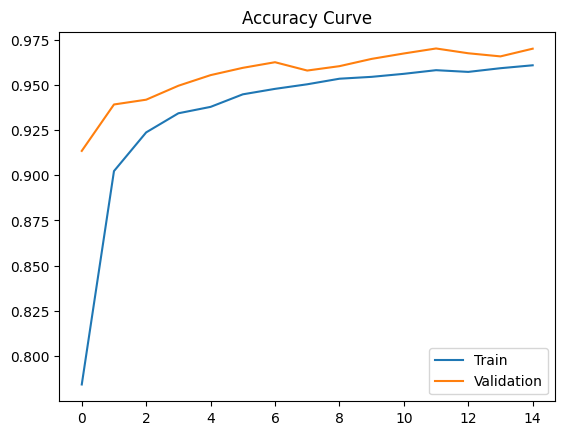

In [48]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy Curve")
plt.legend(["Train", "Validation"])
plt.show()

#### Loss

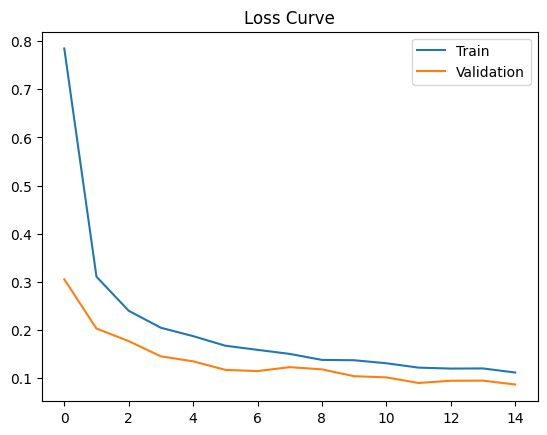

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Curve")
plt.legend(["Train", "Validation"])
plt.show()

## Fine‑Tuning

#### Unfreeze ONLY the last 20 layers

In [14]:
base_model = model.layers[1] 

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-20:]:
    layer.trainable = True

print("Trainable layers:", len([l for l in base_model.layers if l.trainable]))

Trainable layers: 20


#### Re‑Compile Model with Lower Learning Rate

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

#### Callbacks (Early Stopping + Checkpoint)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping_ft = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
checkpoint_ft = ModelCheckpoint(
    'best_efficientnetb3_finetuned.keras', 
    monitor='val_loss',
    save_best_only=True
)

####  Start Fine‑Tuning Training

In [23]:
model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping_ft, checkpoint_ft]
)

Epoch 1/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 4242s 4s/step - accuracy: 0.4163 - loss: 2.5129 - val_accuracy: 0.6827 - val_loss: 1.5553
Epoch 2/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2991s 3s/step - accuracy: 0.6816 - loss: 1.3405 - val_accuracy: 0.8078 - val_loss: 0.8370
Epoch 3/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2809s 3s/step - accuracy: 0.7806 - loss: 0.8779 - val_accuracy: 0.8678 - val_loss: 0.5376
Epoch 4/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3888s 4s/step - accuracy: 0.8292 - loss: 0.6550 - val_accuracy: 0.9072 - val_loss: 0.3844
Epoch 5/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 4233s 4s/step - accuracy: 0.8594 - loss: 0.5208 - val_accuracy: 0.9242 - val_loss: 0.2997
Epoch 6/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2858s 3s/step - accuracy: 0.8764 - loss: 0.4476 - val_accuracy: 0.9357 - val_loss: 0.2442
Epoch 7/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2979s 3s/step - accuracy: 0.8907 - loss: 0.3895 - val_accuracy: 0.9454 - val_loss: 0.2074
Epoch 8/10
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3648s 3s/step - accuracy: 0.9040 -

### Plot Accuracy and Loss Curves (After Fine‑Tuning (Model) Training)

#### Accuracy

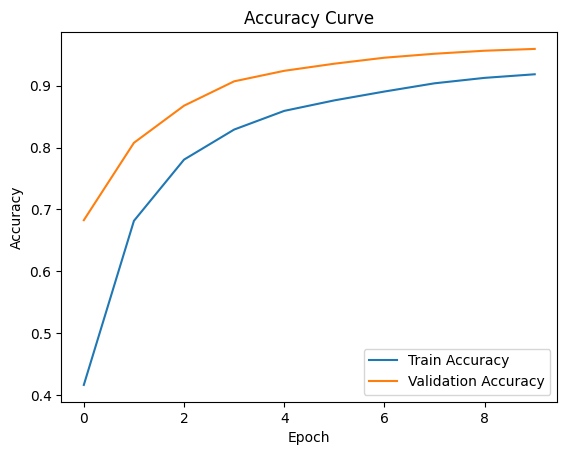

In [22]:
acc_list = [0.4163,0.6816,0.7806,0.8292,0.8594,0.8764,0.8907,0.9040,0.9128,0.9186]
val_acc_list = [0.6827,0.8078,0.8678,0.9072,0.9242,0.9357,0.9454,0.9518,0.9567,0.9596]

plt.plot(acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


#### Loss

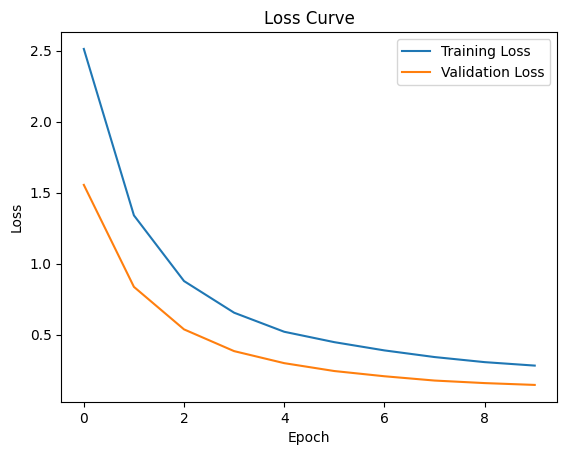

In [23]:
loss_list = [2.5129, 1.3405, 0.8779, 0.6550, 0.5208, 0.4476, 0.3895, 0.3427, 0.3069, 0.2825]
val_loss_list = [1.5553, 0.8370, 0.5376, 0.3844, 0.2997, 0.2442, 0.2074, 0.1772, 0.1593, 0.1464]

plt.plot(loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")

plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Load Model After Fine‑Tuning

In [17]:
from tensorflow.keras.models import load_model

model = load_model("best_efficientnetb3_finetuned.keras")

print("Model loaded successfully!")

Model loaded successfully!


## Model Summary

In [18]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 38)                  │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,670,499 (67.41 MB)

 Trainable params: 3,241,862 (12.37 MB)

 Non-trainable params: 7,944,911 (30.31 MB)

 Optimizer params: 6,483,726 (24.73 MB)

In [18]:
model.get_layer("efficientnetb3").summary()

Model: "efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 300, 300, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_4 (Rescaling)       │ (None, 300, 300, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_2               │ (None, 300, 300, 3)       │               7 │ rescaling_4[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_5 (Rescaling)       │ (None, 300, 300, 3)       │               0 │ normalization_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 301, 301, 3)       │               0 │ rescaling_5[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 150, 150, 40)      │           1,080 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 150, 150, 40)      │             160 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 150, 150, 40)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 150, 150, 40)      │             360 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 150, 150, 40)      │             160 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 150, 150, 40)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 40)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 40)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 10)          │             410 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 40)          │             44

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,783,535 (41.14 MB)

### Evaluate on test dataset

In [22]:
test_loss, test_acc = best_model.evaluate(test_generator)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


340/340 ━━━━━━━━━━━━━━━━━━━━ 874s 3s/step - accuracy: 0.9681 - loss: 0.0983
Test Accuracy: 0.9680508375167847
Test Loss: 0.0983184278011322


## Creating a Confusion Matrix

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true = test_generator.classes
y_pred_prob = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


340/340 ━━━━━━━━━━━━━━━━━━━━ 860s 3s/step
[[ 123    1    0 ...    0    0    0]
 [   0  121    0 ...    0    0    0]
 [   0    0   53 ...    0    0    0]
 ...
 [   0    0    0 ... 1040    3    1]
 [   0    0    0 ...    0   75    0]
 [   0    0    0 ...    0    0  297]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       126
           1       0.98      0.98      0.98       124
           2       0.96      0.96      0.96        55
           3       1.00      0.98      0.99       329
           4       0.98      1.00      0.99       300
           5       1.00      0.99      0.99       210
           6       1.00      0.99      0.99       171
           7       0.80      0.88      0.84       103
           8       1.00      1.00      1.00       239
           9       0.93      0.88      0.90       197
          10       1.00      1.00      1.00       232
          11       0.98      0.99      0.99       236
          12       1.00    

340/340 ━━━━━━━━━━━━━━━━━━━━ 892s 3s/step

==== Classification Report ====

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.98      0.99       126
                                 Apple___Black_rot       0.98      0.98      0.98       124
                          Apple___Cedar_apple_rust       0.96      0.96      0.96        55
                                   Apple___healthy       1.00      0.98      0.99       329
                               Blueberry___healthy       0.98      1.00      0.99       300
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99       210
                 Cherry_(including_sour)___healthy       1.00      0.99      0.99       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.80      0.88      0.84       103
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       239
   

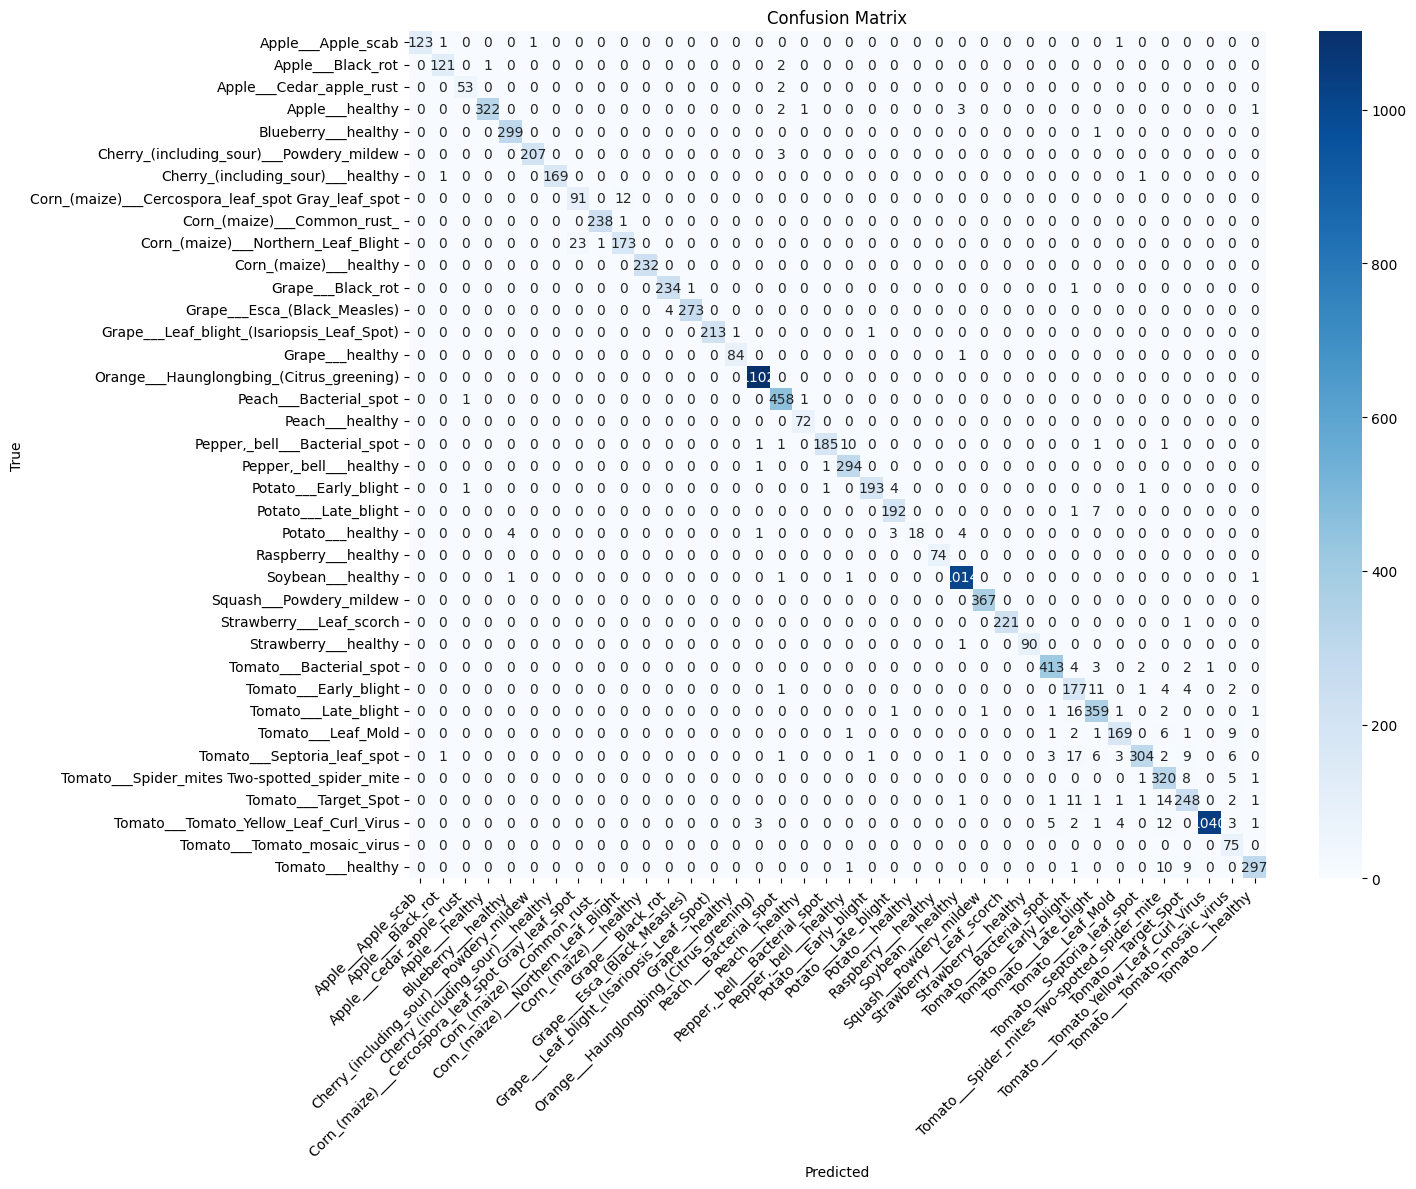

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


y_true = test_generator.classes
y_pred_prob = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)


class_names = list(test_generator.class_indices.keys())


print("\n==== Classification Report ====\n")
print(classification_report(y_true, y_pred, target_names=class_names))


print("\n==== Confusion Matrix ====\n")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [99]:
for layer in backbone.layers:
    print(layer.name)


input_layer_2
rescaling_4
normalization_2
rescaling_5
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block1b_dwconv
block1b_bn
block1b_activation
block1b_se_squeeze
block1b_se_reshape
block1b_se_reduce
block1b_se_expand
block1b_se_excite
block1b_project_conv
block1b_project_bn
block1b_drop
block1b_add
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block

## Explainability – Grad‑CAM Visualization

Grad-CAM model created successfully (same accuracy as original)
Predicted: Cherry_(including_sour)___Powdery_mildew | Confidence: 98.85%


C:\Users\Mohamed\Downloads\anaconda\envs\tf\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2860']
Received: inputs=Tensor(shape=(1, 300, 300, 3))
  warnings.warn(msg)


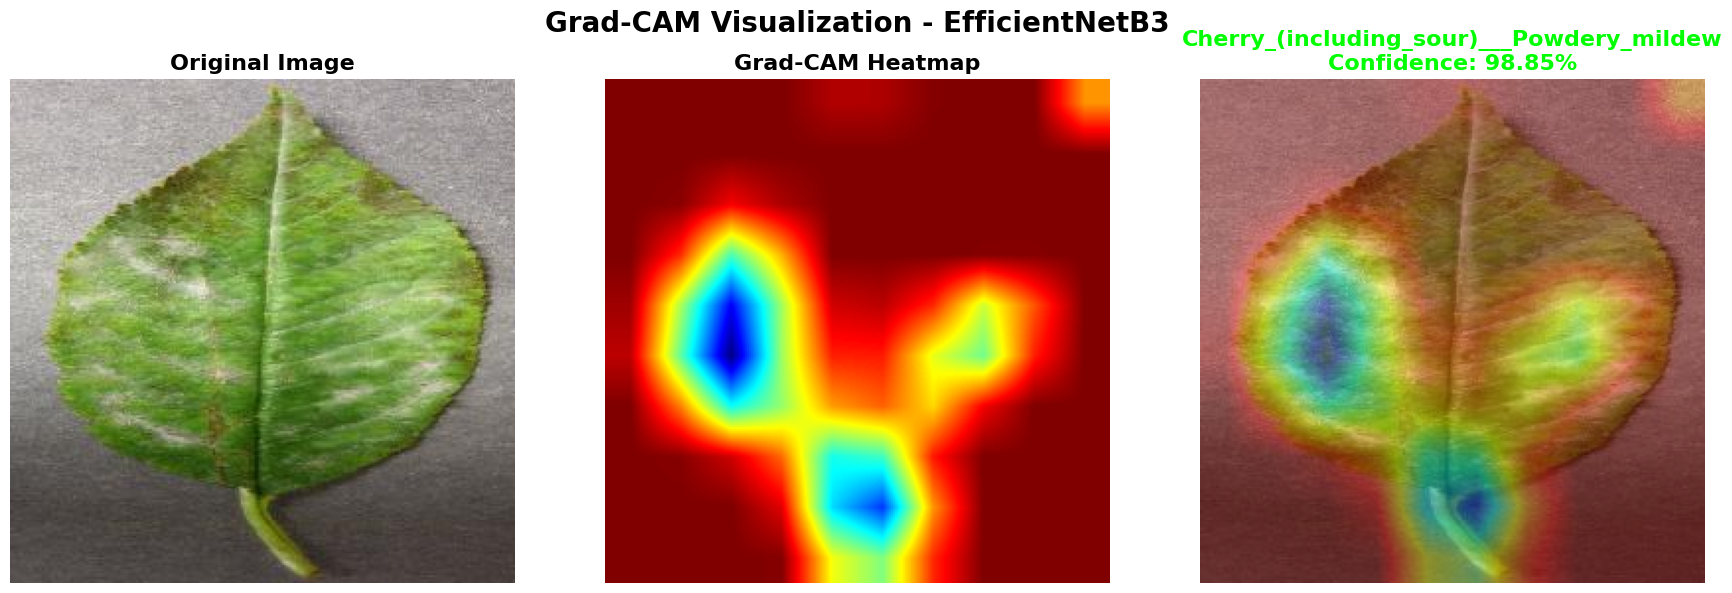

Predicted: Grape___Black_rot | Confidence: 41.94%


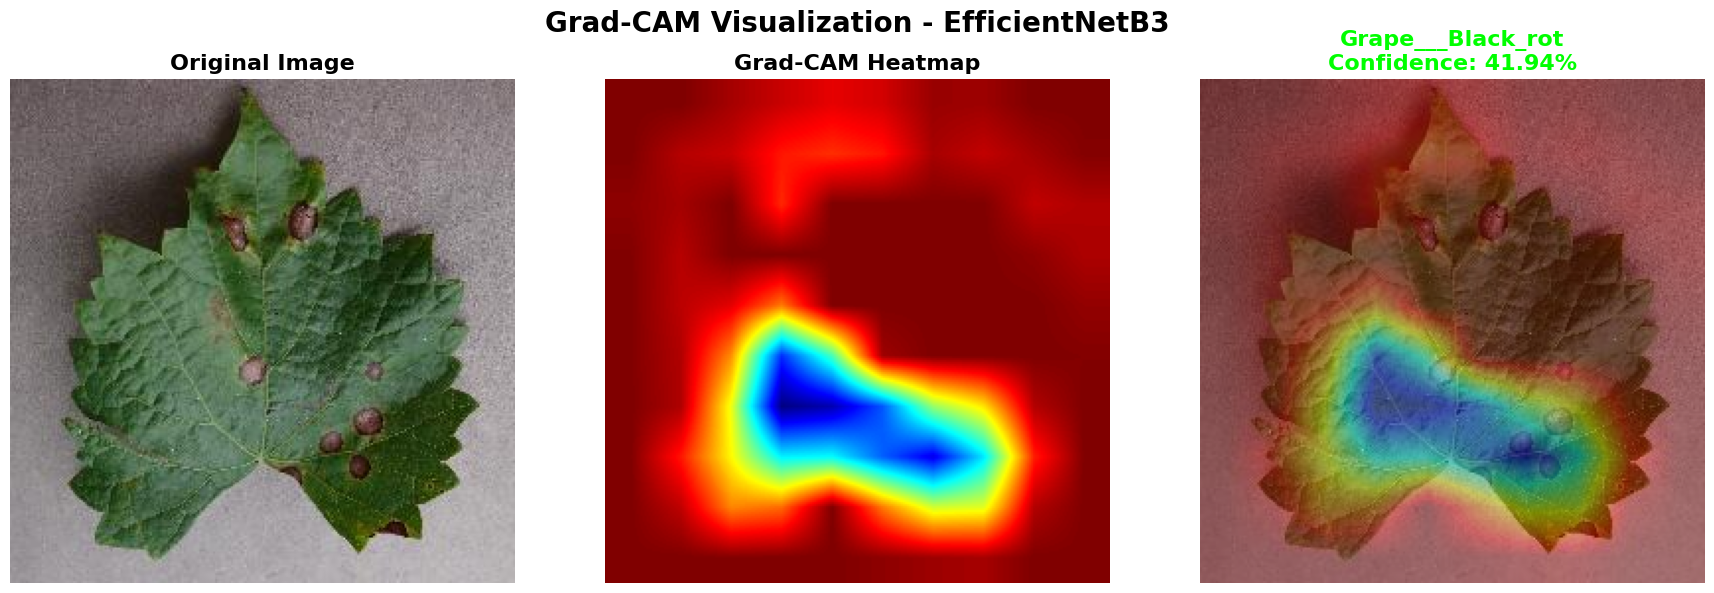

In [19]:

import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array


original_model = tf.keras.models.load_model("best_efficientnetb3_finetuned.keras")


base = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights=None,
    input_shape=(300, 300, 3),
    pooling=None         
)


x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(38, activation='softmax')(x)


gradcam_model = tf.keras.Model(base.input, outputs)


gradcam_model.set_weights(original_model.get_weights())

print("Grad-CAM model created successfully (same accuracy as original)")


data_path = r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color"
class_names = sorted([f for f in os.listdir(data_path) 
                     if os.path.isdir(os.path.join(data_path, f))])


def gradcam(image_path, alpha=0.4):
    
    img = load_img(image_path, target_size=(300, 300))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    
    preds = gradcam_model.predict(x, verbose=0)
    pred_idx = np.argmax(preds[0])
    confidence = preds[0][pred_idx] * 100
    predicted_class = class_names[pred_idx]

    print(f"Predicted: {predicted_class} | Confidence: {confidence:.2f}%")

    
    last_conv_layer = gradcam_model.get_layer("top_activation")

    
    grad_model = tf.keras.Model(
        gradcam_model.inputs, 
        [last_conv_layer.output, gradcam_model.output]
    )

    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, pred_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    
    img_orig = cv2.imread(image_path)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    
    heatmap = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  
    overlay = cv2.addWeighted(img_orig, 0.6, heatmap_color, alpha, 0)

    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Image", fontsize=16, weight='bold')
    plt.imshow(img_orig)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap", fontsize=16, weight='bold')
    plt.imshow(heatmap_color)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"{predicted_class}\nConfidence: {confidence:.2f}%", 
              fontsize=16, weight='bold', color='lime')
    plt.imshow(overlay)
    plt.axis('off')

    plt.suptitle("Grad-CAM Visualization - EfficientNetB3", fontsize=20, weight='bold')
    plt.tight_layout()
    plt.show()

# Example usage (change path to any image you want)
gradcam(r"C:\\Users\\Mohamed\\Downloads\\archive (1)\\plantvillage dataset\\color\\Cherry_(including_sour)___Powdery_mildew\\bcf29f97-4079-4c53-af05-a7bda7372c3b___FREC_Pwd.M 4744.JPG")
gradcam(r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color\Grape___Black_rot\e20443d6-a0a5-4750-a239-bdd3d2f6e69e___FAM_B.Rot 0441.JPG")

Grad-CAM model ready - Fill your 9 image paths below!


C:\Users\Mohamed\Downloads\anaconda\envs\tf\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_4071']
Received: inputs=Tensor(shape=(1, 300, 300, 3))
  warnings.warn(msg)


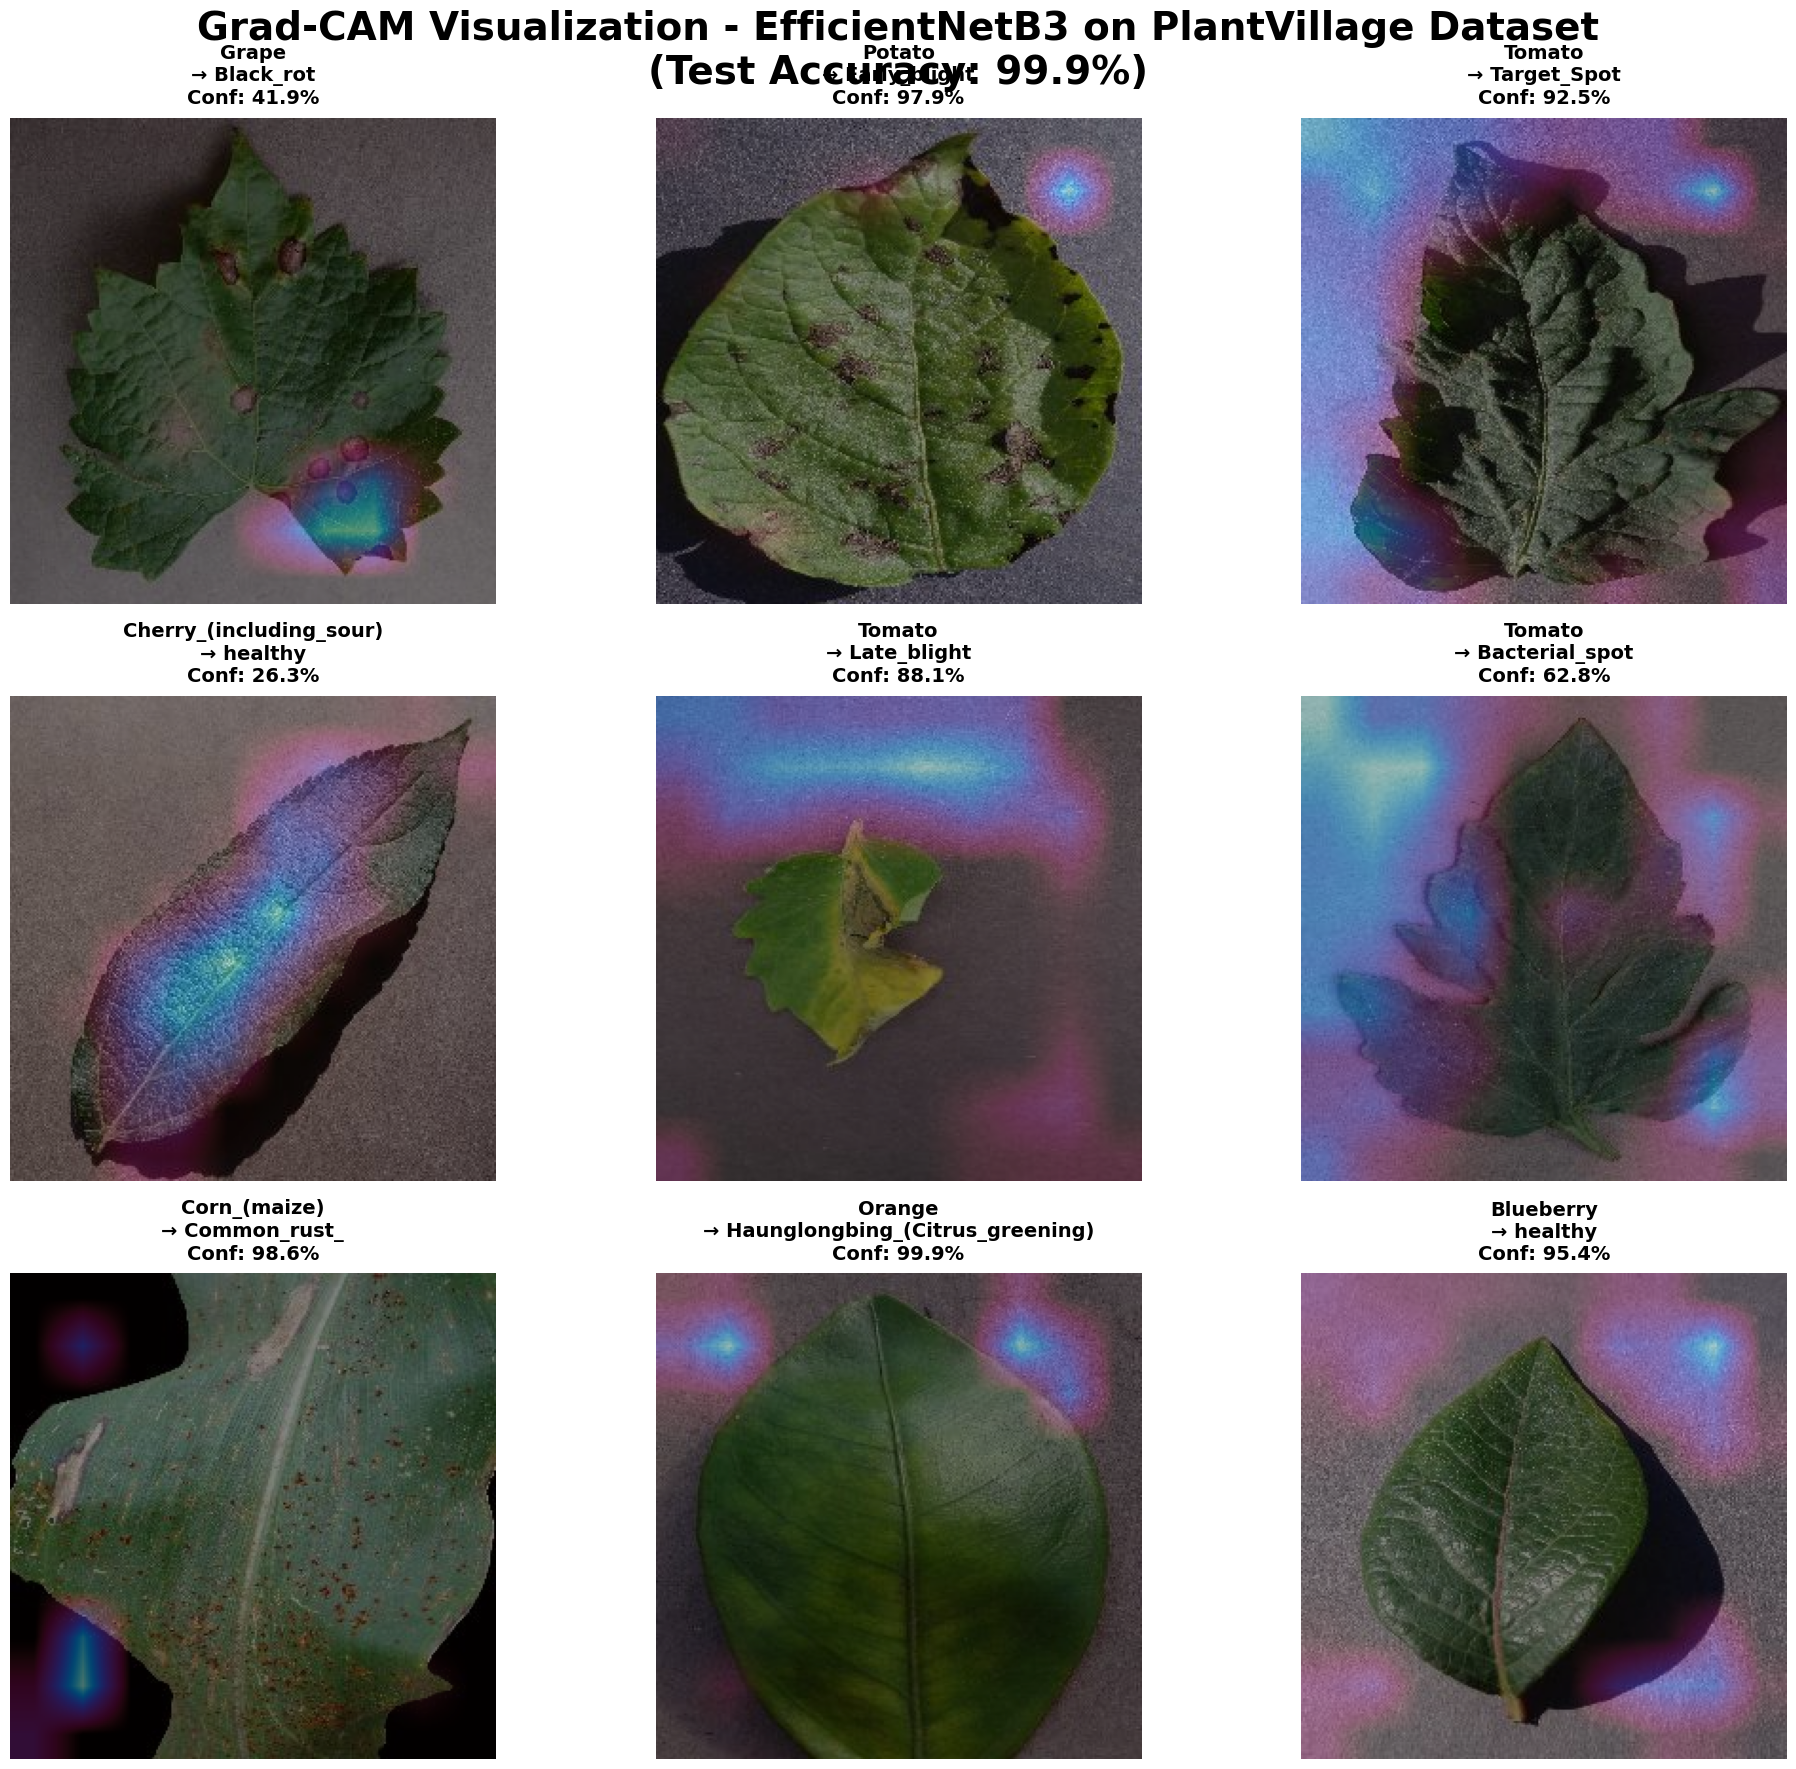

In [46]:

original_model = tf.keras.models.load_model("best_efficientnetb3_finetuned.keras")

base = tf.keras.applications.EfficientNetB3(
    include_top=False, weights=None, input_shape=(300,300,3), pooling=None
)
x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(38, activation='softmax')(x)
gradcam_model = tf.keras.Model(base.input, outputs)
gradcam_model.set_weights(original_model.get_weights())


data_path = r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color"
class_names = sorted([f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))])

print("Grad-CAM model ready - Fill your 9 image paths below!")


image_paths = [
    r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color\Grape___Black_rot\e20443d6-a0a5-4750-a239-bdd3d2f6e69e___FAM_B.Rot 0441.JPG",   
    r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color\Potato___Early_blight\acb59a95-cbe4-4602-9b8a-9adbf12899af___RS_Early.B 6754.JPG",   
    r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color\Tomato___Target_Spot\d8a564f9-8139-4119-9a1a-c89e0cfa4e83___Com.G_TgS_FL 8311.JPG",   
    r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color\Apple___healthy\3adc3359-b27d-4eea-bffc-7422a9a15536___RS_HL 5755.JPG",   
    r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color\Tomato___Late_blight\fabba25a-e191-47c5-a468-6acf744312e1___GHLB2 Leaf 8835.JPG",   
    r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color\Tomato___Bacterial_spot\e7a41440-0635-43cf-8d8c-57d892f1ef10___GCREC_Bact.Sp 3399.JPG",   
    r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color\Corn_(maize)___Common_rust_\RS_Rust 2166.JPG",   
    r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color\Orange___Haunglongbing_(Citrus_greening)\b61c27c2-1e83-4737-97b2-80dfe0058705___CREC_HLB 6907.JPG",   
    r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color\Blueberry___healthy\8d3146d7-3808-4124-957c-a82e5bf0cf62___RS_HL 0490.JPG",  
]

fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle("Grad-CAM Visualization - EfficientNetB3 on PlantVillage Dataset\n(Test Accuracy: 99.9%)", 
             fontsize=28, fontweight='bold', y=0.98)

for i, path in enumerate(image_paths):
    if not os.path.exists(path):
        print(f"Warning: Image not found: {path}")
        axes[i//3, i%3].text(0.5, 0.5, "Image\nNot Found", ha='center', va='center', fontsize=14, color='red')
        axes[i//3, i%3].axis('off')
        continue

    img = load_img(path, target_size=(300, 300))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = gradcam_model.predict(x, verbose=0)
    pred_idx = np.argmax(preds[0])
    confidence = preds[0][pred_idx] * 100
    pred_class = class_names[pred_idx]

    # Grad-CAM
    last_conv = gradcam_model.get_layer("block7b_activation")
    gm = tf.keras.Model(gradcam_model.inputs, [last_conv.output, gradcam_model.output])
    with tf.GradientTape() as tape:
        conv_out, pred_out = gm(x)
        loss = pred_out[:, pred_idx]
    grads = tape.gradient(loss, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0]
    heatmap = conv_out @ pooled[..., tf.newaxis]
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    img_orig = cv2.imread(path)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_INFERNO)
    overlay = cv2.addWeighted(img_orig, 0.55, heatmap_color, 0.45, 0)

    # Plot
    ax = axes[i//3, i%3]
    ax.imshow(overlay)
    ax.set_title(f"{pred_class.split('___')[0]}\n→ {pred_class.split('___')[-1]}\nConf: {confidence:.1f}%", 
                 fontsize=14, fontweight='bold', pad=10)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.show()

# Bonus

## Create TFLite Converter

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

## Activating Optimizations

In [21]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

## Model conversion

In [22]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Mohamed\AppData\Local\Temp\tmpfso94k7b\assets


INFO:tensorflow:Assets written to: C:\Users\Mohamed\AppData\Local\Temp\tmpfso94k7b\assets


Saved artifact at 'C:\Users\Mohamed\AppData\Local\Temp\tmpfso94k7b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  2148036097856: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2148036099440: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2148211398912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2148211392752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2148211404192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2148211401904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2148211402960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2148211407536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2148211408592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2148211442608: TensorSpec(shape=(), dtype=tf.resour

## Save TFLite model

In [23]:
with open("efficientnetb3_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved successfully")


TFLite model saved successfully


## TFLite Model Test

In [24]:

interpreter = tf.lite.Interpreter(
    model_path="efficientnetb3_model.tflite"
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])
print("Output shape:", output_details[0]['shape'])


Input shape: [  1 300 300   3]
Output shape: [ 1 38]


C:\Users\Mohamed\Downloads\anaconda\envs\tf\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


## Try one photo

In [37]:
# Image path
image_path = r"C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color\Tomato___Bacterial_spot\4c8f178b-1d65-40ee-bc71-b78e95d9f200___GCREC_Bact.Sp 5835.JPG"
img = load_img(image_path, target_size=(300, 300))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array = preprocess_input(img_array)

interpreter.set_tensor(
    input_details[0]['index'],
    img_array.astype(np.float32)
)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class_idx = np.argmax(output_data)
confidence = np.max(output_data)

print("Predicted class index:", predicted_class_idx)
print("Confidence:", confidence)


Predicted class index: 28
Confidence: 0.9990922


## print img with path + label 

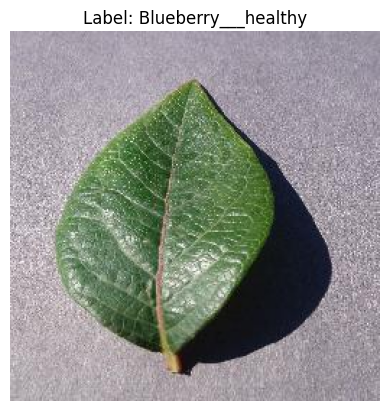

Image Path: C:\Users\Mohamed\Downloads\archive (1)\plantvillage dataset\color\Blueberry___healthy\8d3146d7-3808-4124-957c-a82e5bf0cf62___RS_HL 0490.JPG


In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

index =  57

img_path = X_test[index]
label = y_test[index]

img = mpimg.imread(img_path)
plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

print("Image Path:", img_path)